In [7]:
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
from Dataset import *
from model import *
import torch.utils.data as util_data
from torchvision import transforms,datasets
from PIL import Image, ImageOps
import yaml
from train import *
import random
from easydict import EasyDict as edict

In [8]:
source_train = []
source_test = []
target_train = []
target_test = []

image_size=28
bt_sz = 128
img_transform = transforms.Compose([
    transforms.RandomCrop((image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5),
                         std=(0.5,0.5,0.5))
])
# 'dataset', 'mnist_m', 'mnist_m_train'
# 'dataset', 'mnist_m', 'mnist_m_test'
train_list = os.path.join('dataset', 'mnist_m', 'mnist_m_train_labels.txt')
mnist_m_train = GetLoader(
    data_root=os.path.join('dataset', 'mnist_m', 'mnist_m_train'),
    data_list=train_list,
    transform=img_transform
)
test_list = os.path.join('dataset', 'mnist_m', 'mnist_m_test_labels.txt')
mnist_m_test= GetLoader(
    data_root=os.path.join('dataset', 'mnist_m', 'mnist_m_test'),
    data_list=test_list,
    transform=img_transform
)

source_train = [torch.utils.data.DataLoader(
        datasets.MNIST('./dataset/', train=True, download=False,
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize((0.5,), (0.5,)),
                          transforms.Lambda(lambda x: x.repeat(3, 1, 1))
                      ])),
        batch_size=bt_sz, shuffle=True,drop_last=True),
        torch.utils.data.DataLoader(
        datasets.MNIST('./dataset/', train=True, download=False,
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize((0.5,), (0.5,)),
                          transforms.Lambda(lambda x: x.repeat(3, 1, 1))
                      ])),
        batch_size=bt_sz, shuffle=True,drop_last=True)]

target_train = [torch.utils.data.DataLoader(
        mnist_m_train,batch_size=bt_sz, shuffle=True,drop_last=True),
        torch.utils.data.DataLoader(
        mnist_m_train,batch_size=bt_sz, shuffle=True,drop_last=True)]

source_test = [torch.utils.data.DataLoader(
        datasets.MNIST('./dataset/', train=False, download=False,
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize((0.5,), (0.5,)),
                          transforms.Lambda(lambda x: x.repeat(3, 1, 1))
                      ])),
        batch_size=bt_sz, shuffle=False,drop_last=True),
        torch.utils.data.DataLoader(
        datasets.MNIST('./dataset/', train=False, download=False,
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize((0.5,), (0.5,)),
                          transforms.Lambda(lambda x: x.repeat(3, 1, 1))
                      ])),
        batch_size=bt_sz, shuffle=False,drop_last=True)]

target_test = [torch.utils.data.DataLoader(
        mnist_m_test,batch_size=bt_sz, shuffle=False,drop_last=True),
        torch.utils.data.DataLoader(
        mnist_m_test,batch_size=bt_sz, shuffle=False,drop_last=True)]

In [9]:
with open('dann.yml','r') as f:
  cfg = edict(yaml.load(f))
for x in cfg:
  print('{}: {}'.format(x, cfg[x]))

init_lr: 0.01
optim: {'type': 'sgd', 'params': {'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.001, 'nesterov': True}}
lr_scheduler: {'type': 'inv', 'gamma': 0.001, 'decay_rate': 0.75}


In [10]:
max_iter = 15000.0
width = 128
base_net = 'mnist_net'
class_num = [5,2]

model_instance = MUD(base_net_sha=base_net,\
                    width=width, use_gpu=True, class_num=class_num,\
                    max_iter=max_iter, alpha=10., \
                    low_value=0., high_value=1.,\
                    gamma=1., weight=1.)

param_groups = model_instance.get_parameter_list()
group_ratios = [group['lr'] for group in param_groups]

optimizer = torch.optim.SGD(param_groups, **cfg.optim.params)
lr_scheduler = INVScheduler(gamma=cfg.lr_scheduler.gamma,
                decay_rate=cfg.lr_scheduler.decay_rate,
                init_lr=cfg.init_lr)

all_probs_tgt,all_probs_tgt_2,all_probs_src,all_probs_src_2,\
cls_losses,tsf_losses,oth_diffs_s,oth_diffs_t,target_acc1,\
target_acc2, target_acc2_ = train(model_instance,\
              source_train, target_train, target_test,\
              group_ratios, max_iter=max_iter, optimizer=optimizer,\
              lr_scheduler=lr_scheduler, eval_interval=100)



start train...


{'Tgt accuracy': array(0.21004464, dtype=float32)}
{'Tgt accuracy 2': array(0.50591516, dtype=float32)}
{'Src accuracy': array(0.21062034, dtype=float32)}
{'Src accuracy 2': array(0.71047014, dtype=float32)}


{'Tgt accuracy': array(0.6467634, dtype=float32)}
{'Tgt accuracy 2': array(0.7719866, dtype=float32)}
{'Src accuracy': array(0.98616123, dtype=float32)}
{'Src accuracy 2': array(0.99048483, dtype=float32)}


{'Tgt accuracy': array(0.74151784, dtype=float32)}
{'Tgt accuracy 2': array(0.8357143, dtype=float32)}
{'Src accuracy': array(0.9756778, dtype=float32)}
{'Src accuracy 2': array(0.984759, dtype=float32)}


{'Tgt accuracy': array(0.784375, dtype=float32)}
{'Tgt accuracy 2': array(0.85725445, dtype=float32)}
{'Src accuracy': array(0.96724766, dtype=float32)}
{'Src accuracy 2': array(0.9833568, dtype=float32)}


{'Tgt accuracy': array(0.79151785, dtype=float32)}
{'Tgt accuracy 2': array(0.861942, dtype=float32)}
{'Src accuracy': array(0.98106974, dtype=float32)}
{'Src accuracy 2': array(0.9869625, dtype=float32)}


{'Tgt accuracy': array(0.8023437, dtype=float32)}
{'Tgt accuracy 2': array(0.86015624, dtype=float32)}
{'Src accuracy': array(0.98485917, dtype=float32)}
{'Src accuracy 2': array(0.9918036, dtype=float32)}


{'Tgt accuracy': array(0.7959821, dtype=float32)}
{'Tgt accuracy 2': array(0.87165177, dtype=float32)}
{'Src accuracy': array(0.9872129, dtype=float32)}
{'Src accuracy 2': array(0.9932726, dtype=float32)}


{'Tgt accuracy': array(0.8257812, dtype=float32)}
{'Tgt accuracy 2': array(0.8953125, dtype=float32)}
{'Src accuracy': array(0.9660624, dtype=float32)}
{'Src accuracy 2': array(0.9787494, dtype=float32)}


finish train


In [11]:
model_instance.c_net

HMD(
  (base_network_sha): mynet(
    (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(64, 48, kernel_size=(5, 5), stride=(1, 1))
    (relu2): ReLU()
    (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (hier_extractor_layer): Sequential(
    (0): Linear(in_features=768, out_features=768, bias=True)
    (1): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
  )
  (classifier_layer): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=768, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.25, inplace=False)
      (4): Li

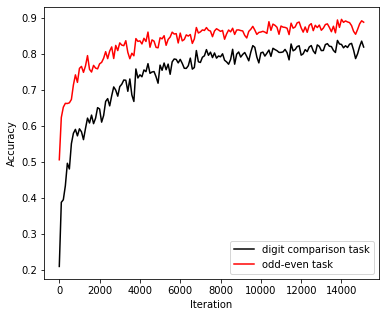

In [12]:
fig = plt.figure(figsize=(6,5))
plt.plot(np.arange(1,15200,100),target_acc1,'k',label='digit comparison task')
plt.plot(np.arange(1,15200,100),target_acc2,'r',label='odd-even task')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.show()